Loading in necessary libraries & data

In [36]:
import fastf1
from fastf1 import plotting
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

In [37]:
cache_dir = os.path.join(os.getcwd(), "cache")
os.makedirs(cache_dir, exist_ok=True)
fastf1.Cache.enable_cache(cache_dir)

In [38]:
fastf1.set_log_level("INFO")

session = fastf1.get_testing_session(2026, 1, 1)
session.load(laps=True)

print("Drivers:", session.drivers)
laps = session.laps
print("Laps loaded:", len(laps))


core           INFO 	Loading data for Pre-Season Testing - Practice 1 [v3.8.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 6
core        WARNING 	Fixed incorrect tyre stint information for driver '11'
core        WARNING 	No lap data for driver 14
core        WARNING 	No lap data for driver 30
core        WARNING 	No lap data for driver 87
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 6)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 14)
core        WARNING 	Failed to perform lap accura

Drivers: ['1', '3', '5', '6', '10', '11', '12', '14', '16', '18', '23', '27', '30', '31', '41', '43', '44', '55', '63', '77', '81', '87']
Laps loaded: 1128


In [39]:
laps = session.laps
print("raw laps:", len(laps))

print(laps[['Driver','LapTime','IsAccurate','PitInTime','PitOutTime']].head(10))


raw laps: 1128
  Driver                LapTime  IsAccurate              PitInTime  \
0    NOR                    NaT       False                    NaT   
1    NOR                    NaT       False 0 days 05:34:57.162000   
2    NOR                    NaT       False                    NaT   
3    NOR                    NaT       False 0 days 05:57:03.244000   
4    NOR                    NaT       False                    NaT   
5    NOR 0 days 00:02:29.258000       False 0 days 06:13:44.081000   
6    NOR                    NaT       False                    NaT   
7    NOR 0 days 00:02:26.633000       False 0 days 06:25:14.764000   
8    NOR                    NaT       False                    NaT   
9    NOR 0 days 00:02:29.847000       False 0 days 06:41:46.890000   

              PitOutTime  
0 0 days 05:30:31.076000  
1                    NaT  
2 0 days 05:52:38.791000  
3                    NaT  
4 0 days 06:09:29.789000  
5                    NaT  
6 0 days 06:21:01.307000 

Cleaning Data

In [50]:
laps_clean = session.laps.dropna(subset=(["LapTime"])) #remove laps without a recorded lap time
laps_clean = laps_clean[laps_clean["IsAccurate"] == True] #keep only laps marked as accurate by FastF1

CUTOFF = 120 #seconds

laps_comp = laps_clean[laps_clean["LapTime"] < pd.Timedelta(seconds=CUTOFF)] #Keep only "competitive" laps(faster than 2:00, removes pit/slow laps)

print("Clean laps:", len(laps_clean))
print("Competitive laps:", len(laps_comp))

Clean laps: 718
Competitive laps: 618


Fastest lap comparison

In [52]:
fastest_per_driver = laps_comp.groupby("Driver")["LapTime"].min().sort_values()
print(fastest_per_driver)

Driver
NOR   0 days 00:01:34.669000
VER   0 days 00:01:34.798000
LEC   0 days 00:01:35.190000
OCO   0 days 00:01:35.578000
PIA   0 days 00:01:35.602000
RUS   0 days 00:01:36.108000
HAM   0 days 00:01:36.433000
GAS   0 days 00:01:36.765000
HUL   0 days 00:01:36.861000
ALB   0 days 00:01:37.437000
ANT   0 days 00:01:37.629000
LIN   0 days 00:01:37.945000
SAI   0 days 00:01:38.221000
PER   0 days 00:01:38.828000
BOR   0 days 00:01:38.871000
BOT   0 days 00:01:39.150000
STR   0 days 00:01:39.883000
COL   0 days 00:01:40.330000
Name: LapTime, dtype: timedelta64[ns]


In [55]:
def format_lap(td):
    total_seconds = td.total_seconds()
    minutes = int(total_seconds // 60)
    seconds = total_seconds % 60
    return f"{minutes:02d}:{seconds:06.3f}"

formatted = fastest_per_driver.apply(format_lap)

print(formatted)

Driver
NOR    01:34.669
VER    01:34.798
LEC    01:35.190
OCO    01:35.578
PIA    01:35.602
RUS    01:36.108
HAM    01:36.433
GAS    01:36.765
HUL    01:36.861
ALB    01:37.437
ANT    01:37.629
LIN    01:37.945
SAI    01:38.221
PER    01:38.828
BOR    01:38.871
BOT    01:39.150
STR    01:39.883
COL    01:40.330
Name: LapTime, dtype: object


In [59]:
fastest_seconds = fastest_per_driver.dt.total_seconds()
gap_to_fastest = fastest_seconds - fastest_seconds.min()
gap_to_fastest = gap_to_fastest.sort_values() #keep fastest at top/left

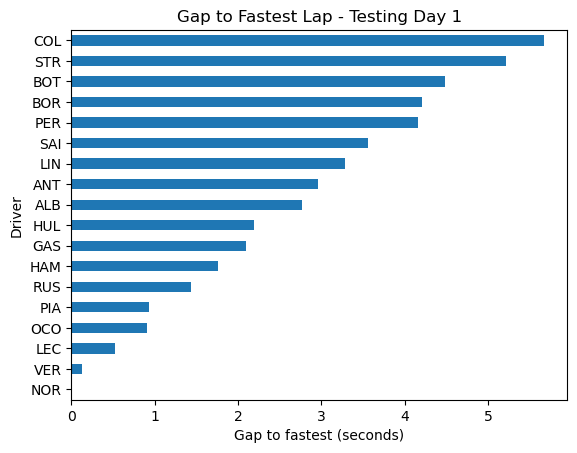

In [68]:
plt.figure()
gap_to_fastest.sort_values(ascending=True).plot(kind = "barh")

plt.title("Gap to Fastest Lap - Testing Day 1")
plt.xlabel("Gap to fastest (seconds)")
plt.ylabel("Driver")
plt.show()

Compound to fastest lap comparison

In [69]:
print(laps_comp["Compound"].value_counts())

Compound
SOFT      359
MEDIUM    169
HARD       90
Name: count, dtype: int64


In [73]:
best_by_driver_compound = (
    laps_comp.groupby(["Driver", "Compound"])["LapTime"]
    .min()
    .sort_values()
)

print(best_by_driver_compound)

Driver  Compound
NOR     MEDIUM     0 days 00:01:34.669000
VER     SOFT       0 days 00:01:34.798000
NOR     SOFT       0 days 00:01:35.164000
LEC     SOFT       0 days 00:01:35.190000
VER     MEDIUM     0 days 00:01:35.433000
OCO     SOFT       0 days 00:01:35.578000
PIA     SOFT       0 days 00:01:35.602000
VER     HARD       0 days 00:01:35.631000
PIA     MEDIUM     0 days 00:01:35.711000
RUS     SOFT       0 days 00:01:36.108000
HAM     SOFT       0 days 00:01:36.433000
GAS     SOFT       0 days 00:01:36.765000
HUL     SOFT       0 days 00:01:36.861000
ALB     SOFT       0 days 00:01:37.437000
ANT     HARD       0 days 00:01:37.629000
LEC     MEDIUM     0 days 00:01:37.819000
LIN     SOFT       0 days 00:01:37.945000
SAI     SOFT       0 days 00:01:38.221000
RUS     HARD       0 days 00:01:38.399000
HUL     MEDIUM     0 days 00:01:38.506000
OCO     MEDIUM     0 days 00:01:38.787000
PER     MEDIUM     0 days 00:01:38.828000
BOR     SOFT       0 days 00:01:38.871000
BOT     HARD     

In [74]:
best_table = best_by_driver_compound.unstack("Compound")
print(best_table)

Compound                   HARD                 MEDIUM                   SOFT
Driver                                                                       
ALB                         NaT                    NaT 0 days 00:01:37.437000
ANT      0 days 00:01:37.629000                    NaT                    NaT
BOR                         NaT 0 days 00:01:39.281000 0 days 00:01:38.871000
BOT      0 days 00:01:39.150000 0 days 00:01:40.317000                    NaT
COL      0 days 00:01:41.997000 0 days 00:01:40.330000                    NaT
GAS                         NaT 0 days 00:01:39.221000 0 days 00:01:36.765000
HAM                         NaT 0 days 00:01:39.269000 0 days 00:01:36.433000
HUL                         NaT 0 days 00:01:38.506000 0 days 00:01:36.861000
LEC                         NaT 0 days 00:01:37.819000 0 days 00:01:35.190000
LIN                         NaT                    NaT 0 days 00:01:37.945000
NOR                         NaT 0 days 00:01:34.669000 0 days 00

Fastest lap comparison (soft tyres)

In [84]:
soft_laps = best_table["SOFT"].dropna().sort_values()
fastest_soft = soft_laps.min()
gap_soft = soft_laps - fastest_soft

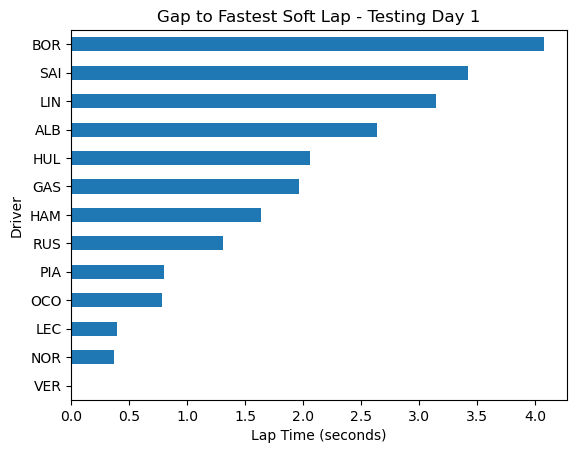

In [85]:
plt.figure()
gap_soft.dt.total_seconds().plot(kind = "barh")

plt.title("Gap to Fastest Soft Lap - Testing Day 1")
plt.xlabel("Gap to fastest Lap Time (seconds)")
plt.ylabel("Driver")
plt.show()

Fastest lap comparison (medium tyre)

In [88]:
medium_laps = best_table["MEDIUM"].dropna().sort_values()
fastest_medium = medium_laps.min()
gap_medium = medium_laps - fastest_medium

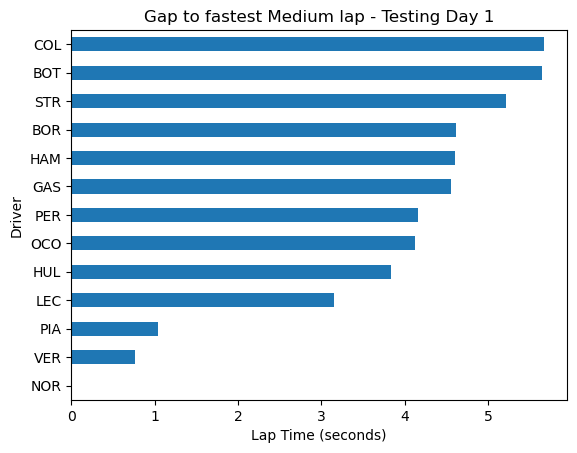

In [89]:
plt.figure()
gap_medium.dt.total_seconds().plot(kind="barh")

plt.title("Gap to fastest Medium lap - Testing Day 1")
plt.xlabel("Lap Time (seconds)")
plt.ylabel("Driver")
plt.show()

Fastest lap comparison (hard tyre)

In [90]:
hard_laps = best_table["HARD"].dropna().sort_values()
fastest_hard = hard_laps.min()
gap_hard = hard_laps - fastest_hard

plt.figure()
gap_hard.dt.total_seconds().plot(kind="barh")

plt.title("Gap to hardest fastest lap - Testing Day 1")
plt.xlabel("Lap Time(seconds)")
plt.ylabel("Driver")
plt.show()

Long run pace analysis